In [1]:
# conda create --name bcitoolbox python=3.10

from bcitoolbox_local import simulateVV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from collections import defaultdict
import statsmodels.api as sm
from scipy.stats import  mannwhitneyu

In [2]:
param_groups = {
    'Prior': ['pcommon', 'sigma_p'],
    'Visual': ['sigma_v'],
}


def get_best_models(model, loc_order=None):
    df = pd.read_csv(f'csv/modeling/outputs/{model}_best_models.csv')
    df['group'] = df['subject_id'].apply(lambda x: 'Low Vision' if str(x).startswith('LV') else 'Control')

    if loc_order is None: loc_order = ['raw', 'visible', 'invisible', '5', '10', '15']
    df['location'] = pd.Categorical(df['location'], categories=loc_order, ordered=True)
    df_means = df.groupby(['location', 'group'], observed=True)[['bic', 'r2']].agg(['mean', 'sem']).round(2)
    df_means = df_means.reindex(loc_order, level='location')
    return df, df_means

def compare_bic_scores():
    
    
    bci_models, bci_means = get_best_models('bci', ['raw'])    
    print('\n======== Bayesian Causal Inference =============')    
    print(bci_means)

    ff_models, ff_means = get_best_models('ff', ['raw'])
    print('\n======== Forced Fusion (p-common = 1) =============')
    print(ff_means)

    fs_models, fs_means = get_best_models('fs', ['raw'])
    print('\n======== Full Segregation (p-common = 0) =============')
    print(fs_means)

    mle_models, mle_means = get_best_models('mle', ['raw'])
    print('\n======== Maximum Likelihood Estimation (no prior) =============')
    print(mle_means)

def find_best_model_per_subject():
    
    bci_models, _ = get_best_models('bci')
    ff_models, _ = get_best_models('ff')
    fs_models, _ = get_best_models('fs')
    mle_models, _ = get_best_models('mle')

    bci_models['model'] = 'bci'
    ff_models['model'] = 'ff'
    fs_models['model'] = 'fs'
    mle_models['model'] = 'mle'

    all_models = pd.concat([bci_models, ff_models, fs_models, mle_models], ignore_index=True)

    idx_of_best_models = all_models.groupby(['subject_id', 'location'], observed=True)['bic'].idxmin()

    best_models_df = all_models.loc[idx_of_best_models]

    loc_order = ['raw', 'visible', 'invisible', '5', '10', '15']
    best_models_df['location'] = pd.Categorical(
        best_models_df['location'], categories=loc_order, ordered=True
    )
    best_models_df = best_models_df.sort_values(
        ['subject_id', 'location']
    ).reset_index(drop=True)
    best_models_df.to_csv('csv/modeling/outputs/best_model_per_subject.csv', index=False)

    return best_models_df

def find_best_bci_model(r2_thres = 0.8):
    
    bci_models, _ = get_best_models('bci')

    # only keep 'raw' location
    bci_models = bci_models[bci_models['location'] == 'raw']

    # filter out bad fit models
    bci_models = bci_models[bci_models['r2'] >= r2_thres]

    idx_of_best_models = bci_models.groupby(['subject_id'], observed=True)['bic'].idxmin()
    best_models_df = bci_models.loc[idx_of_best_models]
    best_models_df.to_csv('csv/modeling/outputs/bci_r2_geq_p8.csv', index=False)
    return best_models_df

def print_parameters(model=None):

    # df, _ = get_best_models(model)
    df = find_best_model_per_subject()

    all_parameters = [p for sublist in param_groups.values() for p in sublist]

    tidy_df = df.melt(
        id_vars=['subject_id', 'location', 'strategy', 'group', 'model'],
        value_vars=all_parameters,
        var_name='parameter',
        value_name='value'
    )

    param_to_type_map = {
        param: group_name 
        for group_name, param_list in param_groups.items() 
        for param in param_list
    }
    tidy_df['parameter_type'] = tidy_df['parameter'].map(param_to_type_map)
    
    print(tidy_df.groupby(['parameter_type', 'parameter', 'location', 'group', 'model'], observed=True)['value'].agg(['mean', 'sem']).round(2))
    output_filename = 'parameter_summary.csv'
    tidy_df.to_csv(output_filename)

def print_strategy(model=None):
    # df, _ = get_best_models(model)
    df = find_best_model_per_subject()
    print(df.groupby(['location', 'group'])['strategy'].value_counts())

def get_significance(p_value, num_comparisons):
    # apply Bonferroni Correction
    if p_value < 0.001 / num_comparisons:
        return '***'
    elif p_value < 0.01 / num_comparisons:
        return '**'
    elif p_value < 0.05 / num_comparisons:
        return '*'
    else:
        return ' (n.s.)'

In [3]:
compare_bic_scores()


======== Bayesian Causal Inference =============
                        bic            r2      
                       mean     sem  mean   sem
location group                                 
raw      Control     238.56   38.18  0.99  0.00
         Low Vision  965.91  134.38  0.87  0.03

======== Forced Fusion (p-common = 1) =============
                         bic            r2      
                        mean     sem  mean   sem
location group                                  
raw      Control      326.62   45.72  0.93  0.02
         Low Vision  1129.88  142.47  0.76  0.03

======== Full Segregation (p-common = 0) =============
                         bic            r2      
                        mean     sem  mean   sem
location group                                  
raw      Control      388.38   46.15  0.87  0.02
         Low Vision  1067.16  135.94  0.78  0.03

======== Maximum Likelihood Estimation (no prior) =============
                         bic            r2    

In [6]:
print_strategy(model='bci')

location   group       strategy 
raw        Control     Averaging    20
                       Matching      1
                       Selection     0
           Low Vision  Averaging    16
                       Matching      5
                       Selection     0
visible    Control     Averaging    20
                       Matching      1
                       Selection     0
           Low Vision  Averaging    13
                       Matching      3
                       Selection     3
invisible  Control     Averaging     5
                       Matching      0
                       Selection     0
           Low Vision  Averaging    15
                       Matching      1
                       Selection     1
5          Control     Averaging    20
                       Matching      1
                       Selection     0
           Low Vision  Averaging    18
                       Matching      3
                       Selection     0
10         Control     Averagin

C:\Users\Ailene\AppData\Local\Temp\ipykernel_33832\2767822081.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(['location', 'group'])['strategy'].value_counts())


In [4]:
bci_best_df = find_best_bci_model()
# print(bci_best_df['subject_id'].unique())
bci_best_df.groupby(['group'])[['pcommon', 'sigma_p', 'sigma_v']].agg(['mean', 'sem']).round(2)

pcommon       sigma_p       sigma_v      
              mean   sem    mean   sem    mean   sem
group                                               
Control       0.81  0.06    1.64  0.21    0.35  0.03
Low Vision    0.63  0.11    1.04  0.23    0.32  0.05

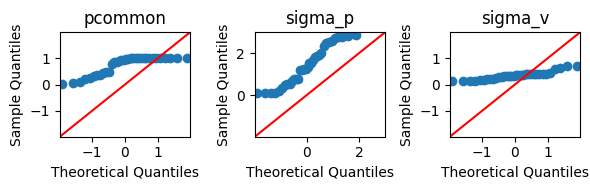

Comparing 3 parameters between Low Vision and Control subjects.

========== Location: raw ==========

--- Testing Parameter: pcommon ---
   - U Statistic = 101.00
   - p-value = 0.215 (n.s.)

--- Testing Parameter: sigma_p ---
   - U Statistic = 82.00
   - p-value = 0.056 (n.s.)

--- Testing Parameter: sigma_v ---
   - U Statistic = 121.00
   - p-value = 0.595 (n.s.)


In [5]:
# best_model, _ = get_best_models('bci')
# best_model = find_best_model_per_subject()
best_model = bci_best_df

groups = ['Low Vision', 'Control']
parameters = ['pcommon', 'sigma_p', 'sigma_v']
locations = ['raw'] #, 'visible', 'invisible', '5', '10', '15']

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 2))

for i, param in enumerate(parameters):
    sm.qqplot(best_model[param], line='45', ax=axes[i])
    axes[i].set_title(param)

plt.tight_layout()
plt.show()

# Since data is not normal, use Mann-Whitney U test (independent groups) to compare parameters across locations

print(f"Comparing {len(parameters)} parameters between Low Vision and Control subjects.")

for loc in locations:
    print(f'\n========== Location: {loc} ==========')
    for param in parameters:
        print(f"\n--- Testing Parameter: {param} ---")

        group1_data = best_model[(best_model['group'] == 'Low Vision') & (best_model['location'] == loc)][param].dropna()
        group2_data = best_model[(best_model['group'] == 'Control') & (best_model['location'] == loc)][param].dropna()

        if len(group1_data) < 1 or len(group2_data) < 1:
            print(f"Skipping {param} due to insufficient data in one or both groups.\n")
            continue

        stat, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')

        significance_symbol = get_significance(p_value, len(parameters))
        p_string = f"< 0.001" if p_value < 0.001 else f"= {p_value:.3f}"

        print(f"   - U Statistic = {stat:.2f}")
        print(f"   - p-value {p_string}{significance_symbol}") 
